In [1]:
import pcntoolkit as ptk
import pandas as pd
import numpy as np
import pprint
import arviz as az
import matplotlib.pyplot as plt
from pcntoolkit.dataio.norm_data import NormData
from pcntoolkit.normative_model.norm_conf import NormConf
from pcntoolkit.normative_model.norm_hbr import NormHBR
from pcntoolkit.normative_model.norm_factory import load_normative_model
from pcntoolkit.normative_model.norm_factory import create_normative_model
from pcntoolkit.regression_model.hbr.hbr_conf import HBRConf
from pcntoolkit.regression_model.hbr.param import Param

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Load data

In [2]:
# First download the dataset from github
# fcon=pd.read_csv("https://raw.githubusercontent.com/pcn-toolkit/pcn-toolkit/master/resources/data/fcon1000.csv")
fcon = pd.read_csv("resources/data/fcon1000.csv")

In [3]:
# Create a normdata object from the downloaded data
normdata = NormData.from_dataframe(name="full",
                                   dataframe=fcon,
                                   covariates=["age"],
                                   batch_effects=["sex","site"],
                                   response_vars=[ "rh_MeanThickness_thickness"])

display(normdata)

<xarray.NormData>
Dimensions:            (datapoints: 1078, covariates: 1, response_vars: 1,
                        batch_effect_dims: 2)
Coordinates:
  * datapoints         (datapoints) <U14 'datapoint_0' ... 'datapoint_1077'
  * response_vars      (response_vars) <U26 'rh_MeanThickness_thickness'
  * covariates         (covariates) <U3 'age'
  * batch_effect_dims  (batch_effect_dims) <U4 'sex' 'site'
Data variables:
    X                  (datapoints, covariates) float64 25.63 18.34 ... 23.0
    y                  (datapoints, response_vars) float64 2.239 2.376 ... 2.538
    batch_effects      (datapoints, batch_effect_dims) object 1 ... 'SaintLouis'
Attributes:
    name:                full
    batch_effects_maps:  {'sex': {0: 0, 1: 1}, 'site': {'AnnArbor_a': 0, 'Ann...

## Filter out a couple of sites


<BarContainer object of 23 artists>

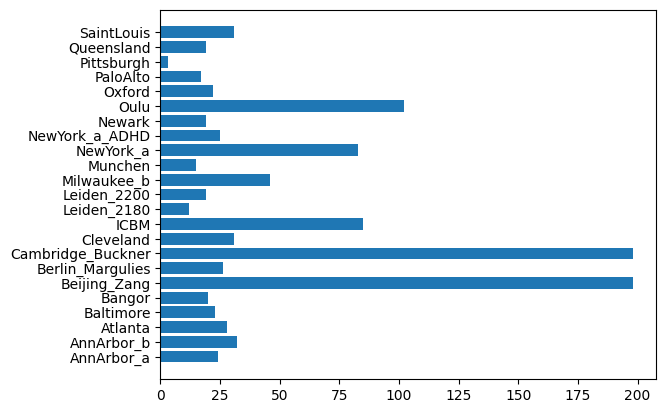

In [4]:
sites = normdata.batch_effects.sel(batch_effect_dims="site").values
unique_sites, counts = np.unique(sites, return_counts=True)
plt.barh(unique_sites, counts)

In [5]:
sites_to_model = ['Oulu','ICBM','Cambridge_Buckner','Beijing_Zang','NewYork_a']
sites_to_transfer_to = ['Milwaukee_b','SaintLouis']
transfer_data = normdata.select_batch_effects({'site':sites_to_transfer_to})
transfer_data.create_batch_effects_maps()
normdata = normdata.select_batch_effects({'site':sites_to_model})
normdata.create_batch_effects_maps()

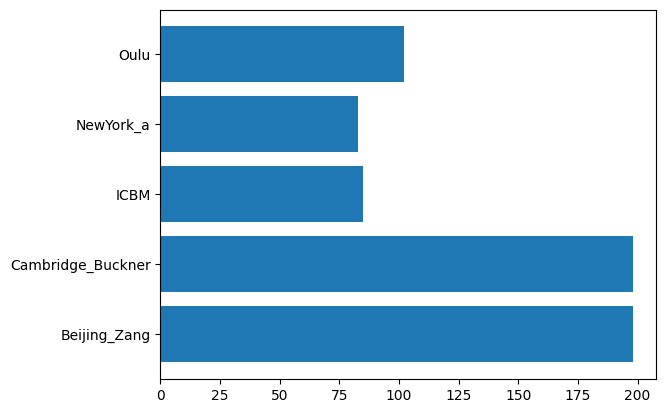

In [6]:

sites = normdata.batch_effects.sel(batch_effect_dims="site").values
unique_sites, counts = np.unique(sites, return_counts=True)
plt.barh(unique_sites, counts)
plt.show()

In [7]:
# Split data into training and test sets
# the splits are automatically stratified on the batch_effects
train, test = normdata.train_test_split(splits=[0.8, 0.2], split_names=["train", "test"])
display(train)
display(test)
transfer_train, transfer_test = transfer_data.train_test_split(splits=[0.8, 0.2], split_names=["transfer_train", "transfer_test"])


<xarray.NormData>
Dimensions:            (datapoints: 532, covariates: 1, response_vars: 1,
                        batch_effect_dims: 2)
Coordinates:
  * datapoints         (datapoints) <U14 'datapoint_830' ... 'datapoint_463'
  * covariates         (covariates) <U3 'age'
  * response_vars      (response_vars) <U26 'rh_MeanThickness_thickness'
  * batch_effect_dims  (batch_effect_dims) <U4 'sex' 'site'
Data variables:
    X                  (datapoints, covariates) float64 49.16 22.0 ... 23.0 19.0
    y                  (datapoints, response_vars) float64 2.399 2.506 ... 2.521
    batch_effects      (datapoints, batch_effect_dims) object 0 ... 'Cambridg...
Attributes:
    name:                train
    batch_effects_maps:  {'sex': {0: 0, 1: 1}, 'site': {'Beijing_Zang': 0, 'C...

<xarray.NormData>
Dimensions:            (datapoints: 134, covariates: 1, response_vars: 1,
                        batch_effect_dims: 2)
Coordinates:
  * datapoints         (datapoints) <U14 'datapoint_212' ... 'datapoint_633'
  * covariates         (covariates) <U3 'age'
  * response_vars      (response_vars) <U26 'rh_MeanThickness_thickness'
  * batch_effect_dims  (batch_effect_dims) <U4 'sex' 'site'
Data variables:
    X                  (datapoints, covariates) float64 19.0 21.0 ... 35.0 20.0
    y                  (datapoints, response_vars) float64 2.612 2.415 ... 2.516
    batch_effects      (datapoints, batch_effect_dims) object 0 ... 'ICBM'
Attributes:
    name:                test
    batch_effects_maps:  {'sex': {0: 0, 1: 1}, 'site': {'Beijing_Zang': 0, 'C...

## Create some synthetic data

In [8]:
synth_data = normdata.create_synthetic_data(n_datapoints=200, range_dim='age')
synth_data

<xarray.NormData>
Dimensions:            (datapoints: 200, covariates: 1, response_vars: 1,
                        batch_effect_dims: 2)
Coordinates:
  * datapoints         (datapoints) <U13 'datapoint_0' ... 'datapoint_199'
  * response_vars      (response_vars) <U26 'rh_MeanThickness_thickness'
  * covariates         (covariates) <U3 'age'
  * batch_effect_dims  (batch_effect_dims) <U4 'sex' 'site'
Data variables:
    X                  (datapoints, covariates) float64 7.88 8.268 ... 85.0
    y                  (datapoints, response_vars) float64 2.52 2.616 ... 2.376
    batch_effects      (datapoints, batch_effect_dims) object 0 ... 'Beijing_...
Attributes:
    name:                full_selected_synthetic
    batch_effects_maps:  {'sex': {0: 0, 1: 1}, 'site': {'Beijing_Zang': 0, 'C...

## Configure the normative model

In [9]:
# Create a NormConf object
norm_conf = NormConf(savemodel=True, 
                    save_dir="resources/save_dir", 
                    log_dir="resources/log_dir",
                    inscaler="standardize",
                    outscaler="standardize",
                    basis_function="linear",
                    order=3,
                    nknots=5)

Configuration of normative model is valid.


## Configure the regression model

In [10]:
# Configure mu
mu = Param(
    name="mu",
    linear=True,
)
# Configure sigma
sigma = Param(
    name="sigma",
    linear=True,
    mapping="softplus"
)
# Configure epsilon
epsilon = Param(
    name="epsilon",
    linear=False,
    dist_name="Normal",
    dist_params=(1,)
)
# Configure delta
delta=Param(
    name="delta",
    linear=False,
    dist_name="HalfNormal",
    dist_params=(1,)
)

# Configure the HBRConf object
hbr_conf = HBRConf(
    draws=1500,
    tune=500,
    chains=4,
    cores=4,
    likelihood="SHASHb",
    mu=mu,
    sigma=sigma,
    epsilon=epsilon,
    delta=delta,
)


Configuration of regression model is valid.


## Combine normative and hbr conf in normative model
We can either use the NormHBR constructor, or the factory method to create a normative HBR model

In [11]:
# Using the constructor
norm_hbr = NormHBR(norm_conf=norm_conf, reg_conf=hbr_conf)
display(norm_hbr)
del norm_hbr

In [12]:
# Using the factory method
norm_hbr = create_normative_model(norm_conf, hbr_conf)
norm_hbr

## Fit the norm_hbr model

In [15]:
norm_hbr.fit(train)

Going to fit 1 models
Fitting model for rh_MeanThickness_thickness


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [slope_mu, intercept_mu, slope_sigma, intercept_sigma, epsilon, delta]


Sampling 2 chains for 500 tune and 1_500 draw iterations (1_000 + 3_000 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## Save the model

In [16]:
# The results are saved in the save_dir specified in the norm_conf
norm_hbr.save()
# del norm_hbr

Saving normative model to resources/save_dir/normative_model_dict.json


## Load the norm_hbr model from disk

In [17]:
norm_hbr = load_normative_model("resources/save_dir")

Loading normative model from resources/save_dir
Configuration of normative model is valid.
Configuration of regression model is valid.


## Predict using the norm_hbr model


In [18]:
norm_hbr.predict(test)

Going to predict 1 models
Predicting model for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing zscores for rh_MeanThickness_thickness
Computing quantiles for rh_MeanThickness_thickness


## Show the results


In [19]:
display(test.measures.to_dataframe())

measures
response_vars              statistics            
rh_MeanThickness_thickness Rho           0.286271
                           RMSE          0.077147
                           SMSE          0.907394
                           ExpV          0.092608
                           MSLL               NaN
                           BIC        -657.241131

In [20]:
display(test)

<xarray.NormData>
Dimensions:            (datapoints: 134, covariates: 1, response_vars: 1,
                        batch_effect_dims: 2, basis_functions: 1,
                        quantile_zscores: 9, statistics: 6)
Coordinates:
  * datapoints         (datapoints) <U14 'datapoint_212' ... 'datapoint_633'
  * covariates         (covariates) <U3 'age'
  * response_vars      (response_vars) <U26 'rh_MeanThickness_thickness'
  * batch_effect_dims  (batch_effect_dims) <U4 'sex' 'site'
  * basis_functions    (basis_functions) <U3 'age'
  * quantile_zscores   (quantile_zscores) float64 -4.0 -3.0 -2.0 ... 2.0 3.0 4.0
  * statistics         (statistics) <U4 'Rho' 'RMSE' 'SMSE' 'ExpV' 'MSLL' 'BIC'
Data variables: (12/15)
    X                  (datapoints, covariates) float64 19.0 21.0 ... 35.0 20.0
    y                  (datapoints, response_vars) float64 2.612 2.415 ... 2.516
    batch_effects      (datapoints, batch_effect_dims) object 0 ... 'ICBM'
    scaled_X           (datapoints, covariates) float64 -0.5131 ... -0.4215
    scaled_y           (datapoints, response_vars) float64 1.243 ... 0.134
    Phi                (datapoints, basis_functions) float64 -0.5131 ... -0.4215
    ...                 ...
    Yhat               (datapoints, response_vars) float64 2.518 2.514 ... 2.516
    S2                 (datapoints, response_vars) float64 0.005738 ... 0.0057
    measures           (response_vars, statistics) float64 0.2863 ... -657.2
    SMSE               (response_vars) float64 0.0
    ExpV               (response_vars) float64 0.0
    BIC                (response_vars) float64 0.0
Attributes:
    name:                test
    batch_effects_maps:  {'sex': {0: 0, 1: 1}, 'site': {'Beijing_Zang': 0, 'C...

In [21]:
test.batch_effects.sel(batch_effect_dims='site')

<xarray.DataArray 'batch_effects' (datapoints: 134)>
array(['Beijing_Zang', 'Cambridge_Buckner', 'Beijing_Zang',
       'Beijing_Zang', 'Cambridge_Buckner', 'Cambridge_Buckner',
       'Beijing_Zang', 'Cambridge_Buckner', 'Cambridge_Buckner',
       'NewYork_a', 'Cambridge_Buckner', 'Beijing_Zang', 'NewYork_a',
       'ICBM', 'NewYork_a', 'Oulu', 'Oulu', 'Cambridge_Buckner',
       'Cambridge_Buckner', 'Oulu', 'Oulu', 'Oulu', 'Beijing_Zang',
       'Cambridge_Buckner', 'Beijing_Zang', 'Beijing_Zang', 'NewYork_a',
       'NewYork_a', 'Beijing_Zang', 'Oulu', 'Oulu', 'Beijing_Zang',
       'ICBM', 'Oulu', 'Oulu', 'Cambridge_Buckner', 'Cambridge_Buckner',
       'Cambridge_Buckner', 'Cambridge_Buckner', 'Cambridge_Buckner',
       'ICBM', 'NewYork_a', 'ICBM', 'Oulu', 'NewYork_a', 'Oulu',
       'NewYork_a', 'NewYork_a', 'ICBM', 'Cambridge_Buckner',
       'Beijing_Zang', 'Cambridge_Buckner', 'NewYork_a',
       'Cambridge_Buckner', 'Oulu', 'Oulu', 'Beijing_Zang',
       'Cambridge_Buckner', 'Beijing_Zang', 'Cambridge_Buckner', 'ICBM',
       'Oulu', 'Beijing_Zang', 'ICBM', 'Beijing_Zang', 'NewYork_a',
       'Cambridge_Buckner', 'NewYork_a', 'NewYork_a', 'Cambridge_Buckner',
       'Beijing_Zang', 'Beijing_Zang', 'Beijing_Zang',
       'Cambridge_Buckner', 'Beijing_Zang', 'Oulu', 'Cambridge_Buckner',
       'Beijing_Zang', 'Cambridge_Buckner', 'Cambridge_Buckner',
       'Cambridge_Buckner', 'NewYork_a', 'Beijing_Zang', 'ICBM', 'ICBM',
       'Beijing_Zang', 'Beijing_Zang', 'Cambridge_Buckner',
       'Beijing_Zang', 'NewYork_a', 'Cambridge_Buckner', 'Beijing_Zang',
       'Beijing_Zang', 'Beijing_Zang', 'Cambridge_Buckner',
       'Beijing_Zang', 'Beijing_Zang', 'ICBM', 'Cambridge_Buckner',
       'Beijing_Zang', 'Cambridge_Buckner', 'Cambridge_Buckner',
       'Beijing_Zang', 'Oulu', 'Cambridge_Buckner', 'Cambridge_Buckner',
       'Cambridge_Buckner', 'Beijing_Zang', 'Oulu', 'ICBM', 'Oulu',
       'Oulu', 'Beijing_Zang', 'ICBM', 'ICBM', 'Cambridge_Buckner',
       'ICBM', 'Cambridge_Buckner', 'Beijing_Zang', 'NewYork_a',
       'Cambridge_Buckner', 'Beijing_Zang', 'Beijing_Zang',
       'Beijing_Zang', 'Beijing_Zang', 'Cambridge_Buckner', 'Oulu',
       'Beijing_Zang', 'Beijing_Zang', 'NewYork_a', 'Cambridge_Buckner',
       'ICBM', 'ICBM', 'ICBM'], dtype=object)
Coordinates:
  * datapoints         (datapoints) <U14 'datapoint_212' ... 'datapoint_633'
    batch_effect_dims  <U4 'site'

In [22]:
norm_hbr.predict(synth_data)

Sampling: [y_pred]


Going to predict 1 models
Predicting model for rh_MeanThickness_thickness


Computing zscores for rh_MeanThickness_thickness
Computing quantiles for rh_MeanThickness_thickness


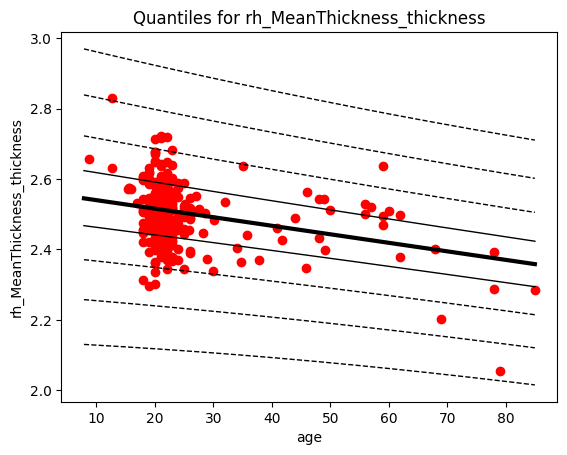

In [23]:
synth_data.plot_quantiles(show_data=True, scatter_data=train)

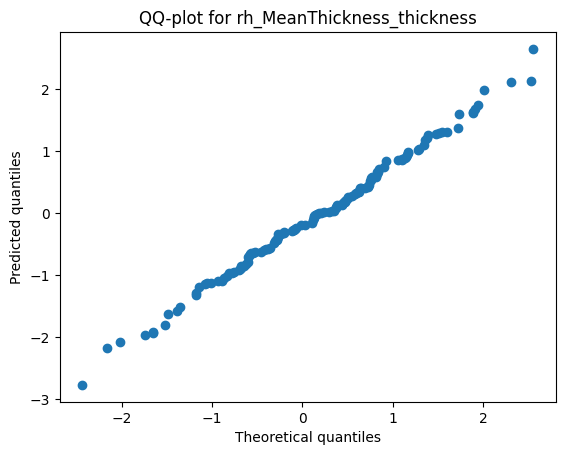

In [24]:
test.plot_qq()

In [25]:
transfered_model = norm_hbr.transfer(transfer_train)

Going to transfer 1 models
Transferring model for rh_MeanThickness_thickness


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [slope_mu, intercept_mu, slope_sigma, intercept_sigma, epsilon, delta]


Sampling 2 chains for 500 tune and 1_500 draw iterations (1_000 + 3_000 draws total) took 202 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [29]:
object.__setattr__(transfered_model.norm_conf, 'save_dir', 'resources/transfer_save_dir')

In [31]:
transfered_model.save()

Saving normative model to resources/transfer_save_dir/normative_model_dict.json


In [28]:
transfered_model = load_normative_model("resources/transfer_save_dir")
transfered_model.predict(transfer_test)

Loading normative model from resources/transfer_save_dir
Configuration of normative model is valid.
Configuration of regression model is valid.
Going to predict 1 models
Predicting model for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing zscores for rh_MeanThickness_thickness
Computing quantiles for rh_MeanThickness_thickness


In [ ]:
transfered_model.prepare("WM-hypointensities")

In [ ]:
post = transfered_model.model.idata.posterior
post

<xarray.Dataset>
Dimensions:                   (chain: 2, draw: 1500, covariates: 8,
                               mu_intercept_mu_dim_0: 1, sex: 2, site: 2,
                               intercept_sigma_dim_0: 1, epsilon_dim_0: 1,
                               sigma_intercept_mu_dim_0: 1, delta_dim_0: 1,
                               datapoints: 61, response_vars: 1)
Coordinates:
  * chain                     (chain) int64 0 1
  * draw                      (draw) int64 0 1 2 3 4 ... 1496 1497 1498 1499
  * covariates                (covariates) <U9 'age' 'bspline_0' ... 'bspline_6'
  * mu_intercept_mu_dim_0     (mu_intercept_mu_dim_0) int64 0
  * sex                       (sex) int64 0 1
  * site                      (site) <U11 'Milwaukee_b' 'SaintLouis'
  * intercept_sigma_dim_0     (intercept_sigma_dim_0) int64 0
  * epsilon_dim_0             (epsilon_dim_0) int64 0
  * sigma_intercept_mu_dim_0  (sigma_intercept_mu_dim_0) int64 0
  * delta_dim_0               (delta_dim_0) int64 0
  * datapoints                (datapoints) <U14 'datapoint_700' ... 'datapoin...
  * response_vars             (response_vars) <U14 'response_var_0'
Data variables: (12/13)
    slope_mu                  (chain, draw, covariates) float64 ...
    mu_intercept_mu           (chain, draw, mu_intercept_mu_dim_0) float64 ...
    offset_intercept_mu       (chain, draw, sex, site) float64 ...
    slope_sigma               (chain, draw, covariates) float64 ...
    intercept_sigma           (chain, draw, intercept_sigma_dim_0) float64 ...
    epsilon                   (chain, draw, epsilon_dim_0) float64 ...
    ...                        ...
    delta                     (chain, draw, delta_dim_0) float64 ...
    intercept_mu              (chain, draw, sex, site) float64 ...
    mu_samples                (chain, draw, datapoints, response_vars) float64 ...
    sigma_samples             (chain, draw, datapoints, response_vars) float64 ...
    epsilon_samples           (chain, draw, datapoints, response_vars) float64 ...
    delta_samples             (chain, draw, datapoints, response_vars) float64 ...
Attributes:
    created_at:                 2024-01-30T19:29:12.754782
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  5.10.3
    sampling_time:              210.47368693351746
    tuning_steps:               500

In [26]:
post.mu_samples

<xarray.DataArray 'mu_samples' (chain: 2, draw: 1500, datapoints: 61,
                                response_vars: 1)>
[183000 values with dtype=float64]
Coordinates:
  * chain          (chain) int64 0 1
  * draw           (draw) int64 0 1 2 3 4 5 6 ... 1494 1495 1496 1497 1498 1499
  * datapoints     (datapoints) <U14 'datapoint_700' ... 'datapoint_699'
  * response_vars  (response_vars) <U14 'response_var_0'

In [38]:
post['mu_samples'] = post.mu_samples.drop_vars(["chain","draw","datapoints","response_vars"])

In [39]:
post.mu_samples

<xarray.DataArray 'mu_samples' (chain: 2, draw: 1500, datapoints: 61,
                                response_vars: 1)>
[183000 values with dtype=float64]
Coordinates:
  * chain          (chain) int64 0 1
  * draw           (draw) int64 0 1 2 3 4 5 6 ... 1494 1495 1496 1497 1498 1499
  * datapoints     (datapoints) <U14 'datapoint_700' ... 'datapoint_699'
  * response_vars  (response_vars) <U14 'response_var_0'

In [40]:
post.mu_samples.values = None

ValueError: replacement data must match the Variable's shape. replacement data has shape (); Variable has shape (2, 1500, 61, 1)

In [42]:
post.drop_vars("mu_samples")

<xarray.Dataset>
Dimensions:                   (chain: 2, draw: 1500, covariates: 8,
                               mu_intercept_mu_dim_0: 1, sex: 2, site: 2,
                               intercept_sigma_dim_0: 1, epsilon_dim_0: 1,
                               sigma_intercept_mu_dim_0: 1, delta_dim_0: 1,
                               datapoints: 61, response_vars: 1)
Coordinates:
  * chain                     (chain) int64 0 1
  * draw                      (draw) int64 0 1 2 3 4 ... 1496 1497 1498 1499
  * covariates                (covariates) <U9 'age' 'bspline_0' ... 'bspline_6'
  * mu_intercept_mu_dim_0     (mu_intercept_mu_dim_0) int64 0
  * sex                       (sex) int64 0 1
  * site                      (site) <U11 'Milwaukee_b' 'SaintLouis'
  * intercept_sigma_dim_0     (intercept_sigma_dim_0) int64 0
  * epsilon_dim_0             (epsilon_dim_0) int64 0
  * sigma_intercept_mu_dim_0  (sigma_intercept_mu_dim_0) int64 0
  * delta_dim_0               (delta_dim_0) int64 0
  * datapoints                (datapoints) <U14 'datapoint_700' ... 'datapoin...
  * response_vars             (response_vars) <U14 'response_var_0'
Data variables:
    slope_mu                  (chain, draw, covariates) float64 ...
    mu_intercept_mu           (chain, draw, mu_intercept_mu_dim_0) float64 ...
    offset_intercept_mu       (chain, draw, sex, site) float64 ...
    slope_sigma               (chain, draw, covariates) float64 ...
    intercept_sigma           (chain, draw, intercept_sigma_dim_0) float64 ...
    epsilon                   (chain, draw, epsilon_dim_0) float64 ...
    sigma_intercept_mu        (chain, draw, sigma_intercept_mu_dim_0) float64 ...
    delta                     (chain, draw, delta_dim_0) float64 ...
    intercept_mu              (chain, draw, sex, site) float64 ...
    sigma_samples             (chain, draw, datapoints, response_vars) float64 ...
    epsilon_samples           (chain, draw, datapoints, response_vars) float64 ...
    delta_samples             (chain, draw, datapoints, response_vars) float64 ...
Attributes:
    created_at:                 2024-01-30T19:29:12.754782
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  5.10.3
    sampling_time:              210.47368693351746
    tuning_steps:               500